# Step 1 Process Data


In [1]:
from mlp import data_loader, metrics,wrapper,transformer,model,preprocessor,rounder

In [2]:

# read data
train, test, train_labels, specs, sample_submission = data_loader.read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, list_title_event_code = data_loader.encode_title(train, test, train_labels)
# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = data_loader.get_train_and_test(train,test, assess_titles,list_of_event_code,list_of_event_id,activities_labels,list_title_event_code,win_code)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns
100%|██████████| 1000/1000 [00:22<00:00, 45.43it/s]


In [3]:

# call feature engineering function
reduce_train, reduce_test, features = preprocessor.preprocess(reduce_train, reduce_test,assess_titles)

In [4]:
all_features= [x for x in reduce_train.columns if x not in ['accuracy_group']]
X_train=reduce_train[all_features]
y_train=reduce_train["accuracy_group"]
X_test=reduce_test[all_features]
y_test=reduce_test["accuracy_group"]

# Step 2 Create regressor model

## lgb

In [5]:
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold)

In [6]:
cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate']

In [7]:
params_lgb = {    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
    'objective': 'regression',
#     'num_iteration': 100,           # add
    'metric': 'rmse',
    'eval_metric': 'cappa',
    'subsample': 0.75,
    'feature_fraction':0.998495,    # add
    'bagging_fraction': 0.872417,   # mod 0.8→
    'bagging_freq': 1,              # add
    'colsample_bytree': 0.8,        # add
    'subsample_freq': 1,
    'learning_rate': 0.02,
    'feature_fraction': 0.9,
    'max_depth': 13,                # mod 10→
    'num_leaves': 1028,             # mod      # 2^max_depth < num_leaves
    'min_gain_to_split':0.085502,   # add
    'min_child_weight':1.087712,    # add
    'lambda_l1': 1,  
    'lambda_l2': 1,
    'verbose': 100,
    'early_stopping_rounds':100
            }

Fold 1 started at Fri Dec 13 23:03:21 2019
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.759038	train's cappa: 0.828458	valid's rmse: 1.01953	valid's cappa: 0.565584
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 0.759038	train's cappa: 0.828458	valid's rmse: 1.01953	valid's cappa: 0.565584
Fold 2 started at Fri Dec 13 23:03:37 2019
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.760022	train's cappa: 0.828201	valid's rmse: 1.01316	valid's cappa: 0.580164
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 0.760022	train's cappa: 0.828201	valid's rmse: 1.01316	valid's cappa: 0.580164
Fold 3 started at Fri Dec 13 23:03:54 2019
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.760141	train's cappa: 0.829888	valid's rmse: 1.03842	valid's cappa: 0.547686
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 0.760141	train's cappa: 0.

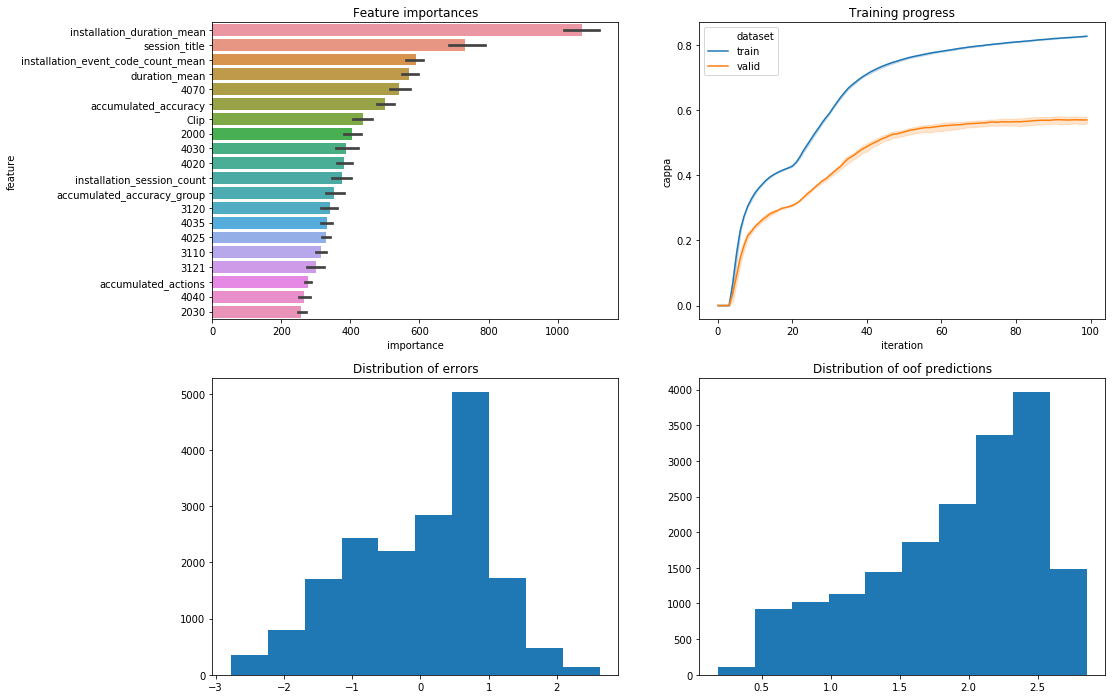

In [8]:
mt = transformer.MainTransformer()
ft = transformer.FeatureTransformer()
transformers = {'ft': ft}
lgbmodel = model.RegressorModel(model_wrapper=wrapper.LGBWrapper_regr())
lgbmodel.fit(X=X_train, y=y_train, folds=folds, params=params_lgb, preprocesser=mt, transformers=transformers,
                    eval_metric='cappa', cols_to_drop=cols_to_drop)
%%time
pred_lgb = lgbmodel.predict_proba(X_test)


## xgboost


In [9]:
params_xgb = {
    'max_depth': 9,                 # 6           # mod 10→9
    'learning_rate': 0.01,          # = eta 0.1: [0,1]
    'objective': 'reg:linear',                    # add
    'n_estimators' : 300,           # 100
    'subsample': 0.6,               # 1, (0,1]    # mod 0.8→0.6
    'colsample_bytree': 1.0,        # 1, (0, 1]   # mod 0.8→1.0
    'gamma': 0.0,                                 # add
    'min_child_weight': 5,                        # add
    'seed' : 42,
    'verbose': 100,
    'early_stopping_rounds':100
}
mt = transformer.MainTransformer()
ft = transformer.FeatureTransformer()
transformers = {'ft': ft}
xgbmodel = model.RegressorModel(model_wrapper=wrapper.XGBWrapper())
xgbmodel.fit(X=X_train, y=y_train, folds=folds, params=params_xgb, preprocesser=mt, transformers=transformers,
                    eval_metric='cappa', cols_to_drop=cols_to_drop)
%%time
pred_xgb = xgbmodel.predict(X_test)


Fold 1 started at Fri Dec 13 23:04:46 2019
[0]	validation_0-merror:0.344404	validation_1-merror:0.411249	validation_0-cappa:-0.58041	validation_1-cappa:-0.47742
Multiple eval metrics have been passed: 'validation_1-cappa' will be used for early stopping.

Will train until validation_1-cappa hasn't improved in 100 rounds.
[100]	validation_0-merror:0.289853	validation_1-merror:0.376201	validation_0-cappa:-0.65592	validation_1-cappa:-0.525479
[200]	validation_0-merror:0.270562	validation_1-merror:0.372809	validation_0-cappa:-0.682377	validation_1-cappa:-0.532921
[299]	validation_0-merror:0.24682	validation_1-merror:0.373092	validation_0-cappa:-0.713013	validation_1-cappa:-0.539925


ValueError: shape mismatch: value array of shape (14152,1) could not be broadcast to indexing result of shape (3538,1)

In [11]:
params_cat={
    "iteration":500,
    "learning_rate":0.02,
    "loss_function": "RMSE",
    "random_seed":42,
    "depth":10,
    "border_count":108,
    "bagging_temperature":2.348502,
    "verbose":100,
    "early_stopping_rounds":100
}
mt = transformer.MainTransformer()
ft = transformer.FeatureTransformer()
transformers = {'ft': ft}
catmodel = model.RegressorModel(model_wrapper=wrapper.CatWrapper())
catmodel.fit(X=X_train, y=y_train, folds=folds, params=params_xgb, preprocesser=mt, transformers=transformers,
                    eval_metric='RMSE', cols_to_drop=cols_to_drop)
%%time
pred_cat = catmodel.predict(X_test)


Fold 1 started at Fri Dec 13 23:23:14 2019


CatBoostError: c:/goagent/pipelines/buildmaster/catboost.gittt/catboost/private/libs/options/loss_description.cpp:17: reg loss is not supported